# Set up 

In [58]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Get the absolute path of the parent directory of the current file (which is 'test')
# current_dir = os.getcwd()
# model_path = os.path.join(current_dir, '..', 'model')
# sys.path.append(model_path)
sys.path.append('..')

from model.Force import HullForce, ControlForce, TowingForce
from model.RigidBody import RigidBody
from model.Simulation import Simulation, Simulation_Result
from model.PlotManager import PlotManager

In [59]:
#Set parameters
m = 0.877 # kg
Vol = 733159.45810955 * 10 ** (-9) #m3
Iyy = 6610.17475482 * 10 ** (-6) #kgm2
hull_surface_area = .0383 #m2
hull_frontal_area = 0.0088
hull_cd = 1.2
hull_corr_factor = 0.75
hull_chord = .215

r_xi = -111.76 * 10 ** (-3) #m 
r_zi = 0.722 * 10 ** (-3) #m

r_xh = 0
r_zh = 0

r_xb = 0
r_zb = 0

r_xt = 42.9 * 10**(-3)
r_zt = -75 * 10**(-3)

# Aero foil parameters
ctrl_chord = 0.1
ctrl_span = 0.261
ctrl_AR = ctrl_span/ctrl_chord #aspect ratio
ctrl_area = ctrl_span*ctrl_chord #planform area
ctrl_stall_threshold = 10 #Angle of attack stall threshold
ctrl_Cl_a = 0.1/np.deg2rad(1)
ctrl_Cl_alpha_offset = 0.5


#Towing parameters
tow_magnitude = 10 #N gets overritten by equilibrium optimization
drone_height = 3 #m above water
drone_tow_length = 5 #m 
probe_depth = 0.3

## Initialize the models

In [60]:
rigidbody = RigidBody(m, Vol, Iyy, np.array([r_xb, r_zb]))
towForce = TowingForce(np.array([r_xt,r_zt]), tow_magnitude, drone_height, drone_tow_length, probe_depth)
controlForce = ControlForce(np.array([r_xi,r_zi]),np.deg2rad(-5), ctrl_AR, ctrl_area, ctrl_chord, ctrl_stall_threshold, ctrl_Cl_a, ctrl_Cl_alpha_offset)
hullForce = HullForce(np.array([r_xh,r_zh]), hull_surface_area, hull_frontal_area, hull_chord, hull_cd, hull_corr_factor)

sim = Simulation(rigidbody,towForce,hullForce,[controlForce])

plot = PlotManager()

# Solve Equilibrium Point

In [ ]:
#Find equilibrium by minimizing Forces and moment individually using least squares
Velocity = 2 #m/s in inertial frame
results_LS = sim.solve_equilibrium_state_LS_Vel(Velocity,1)
_, _ = plot.plotfbd(sim, sim.eq_sim)

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -2.57           degrees   
Delta_t         27.49           degrees   
Towing Force    19.03           N         
Delta_i         6.51            degrees   
----------------------
Inertial Vel X: 0.00           m/s       
Inertial Vel Z: 0.00           m/s       
Pitch Rate:     0.00           rad/s     
Inertial Acc X: 0.00           m/s       
Inertial Acc Z: 0.00           m/s       
Pitch Acc:      0.00           rad/s     
Residual Norm: 0.000000
Optimization successful!


# Equilibrium Simulation

In [ ]:
#print(initial_state)
euler_sim_results = sim.simulate_forward_euler(10000, 0.001, Velocity)
#plot.gen_gif(sim, euler_sim_results)
# plot.plot_simulation_results(euler_sim_results)

In [ ]:
# plot.plot_all_results(euler_sim_results)

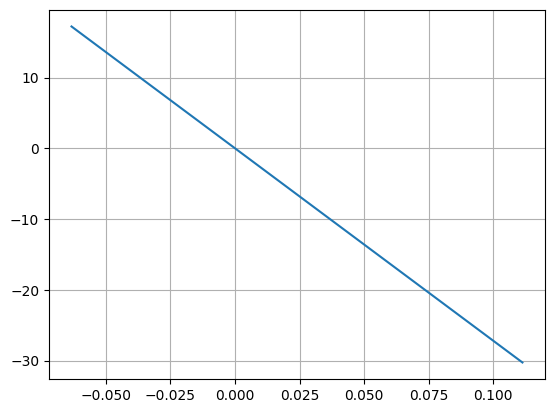

In [ ]:
Cl = []
AoA = []
lift = []
alpha_i = np.linspace(-0.0872665,0.0872665,50)
controlForce.delta_i
for i in alpha_i:
    CL, _, _, AOA = ControlForce.calculate_cl_cd(controlForce, i, 150000)
    Cl.append(CL)
    AoA.append(AOA)
    lift.append( -0.5 * 999.7 * CL * controlForce.Area * 2 ** 2)

plt.plot(AoA,lift)
plt.grid()

# Perturbation Simulation

In [ ]:
perturbed_state = [0, 0, .1, 0, 0 ,0.1] #Change Velocity

pertub_euler_sim_results = sim.simulate_forward_euler(100, 0.001, Velocity, perturbed_state)
# plot.plot_simulation_results(pertub_euler_sim_results)


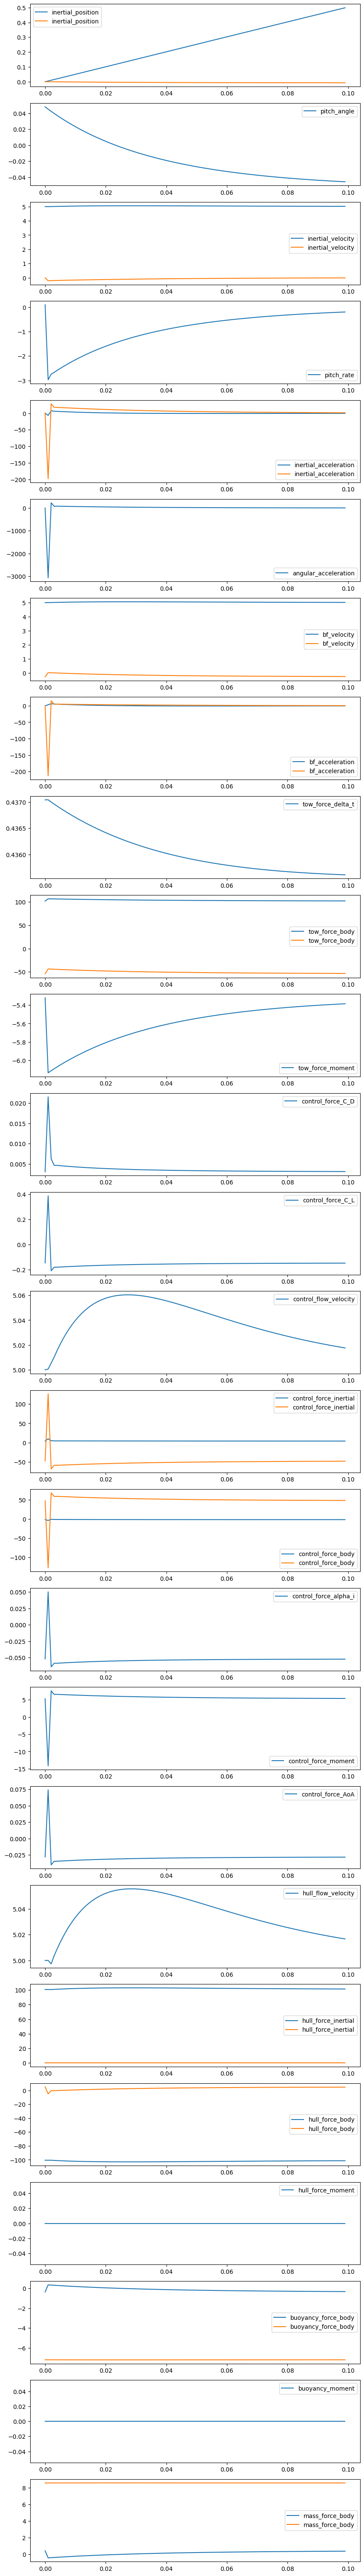

In [ ]:
plot.plot_all_results(pertub_euler_sim_results)

# Jacobian & Eigenvalues

##### Linearized Model

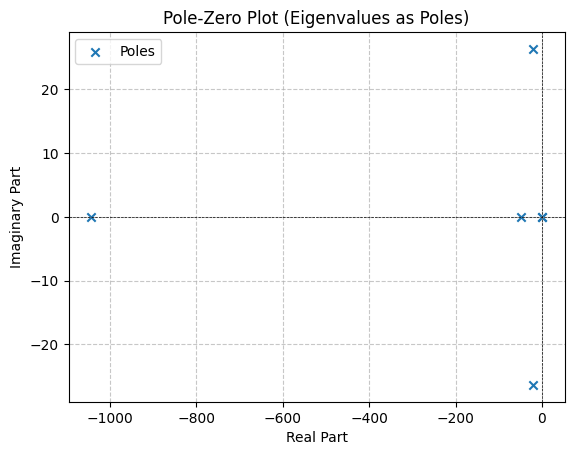

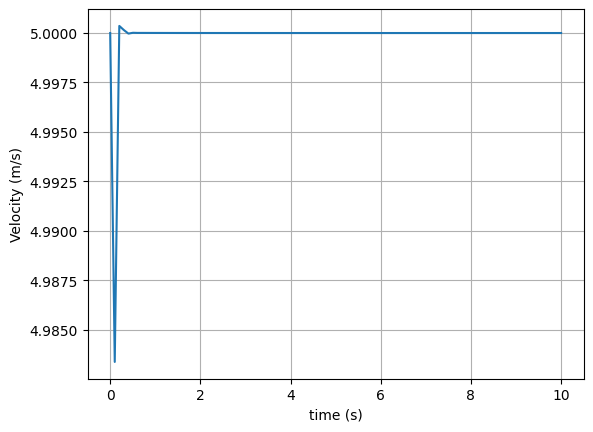

In [ ]:
jacobian, eigenvalues, eigenvectors, X_eq = sim.calculate_jacobian(Velocity, 1e-7)
plot.plot_poles([eigenvalues])
# print(eigenvalues)

## Run Linearized model
def linearized_model(t, x):
    return jacobian @ (x - X_eq)

# Simulate the linearized system using solve_ivp
t_span = (0, 10)  # Time range
perturbed_state[3] += Velocity
solution = solve_ivp(linearized_model, t_span, perturbed_state, t_eval=np.linspace(0, 10, 100))
plt.plot(solution.t,solution.y[3])
plt.xlabel("time (s)")
plt.ylabel("Velocity (m/s)")
plt.grid()

##### Velocity Sensitivity Sweeps

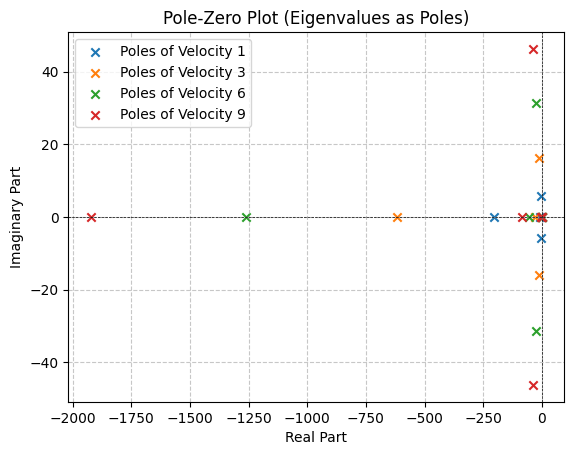

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Pole-Zero Plot (Eigenvalues as Poles)'}, xlabel='Real Part', ylabel='Imaginary Part'>)

In [ ]:
V = [1, 3, 6, 9]
eigs = []
input = ["Velocity", V]
for vel in V:
    jacobian, eigenvalues, eigenvectors, X_eq = sim.calculate_jacobian(vel, 1e-7)
    eigs.append(eigenvalues)
plot.plot_poles(eigs, input)

##### Tow Point Sensitivity Sweeps

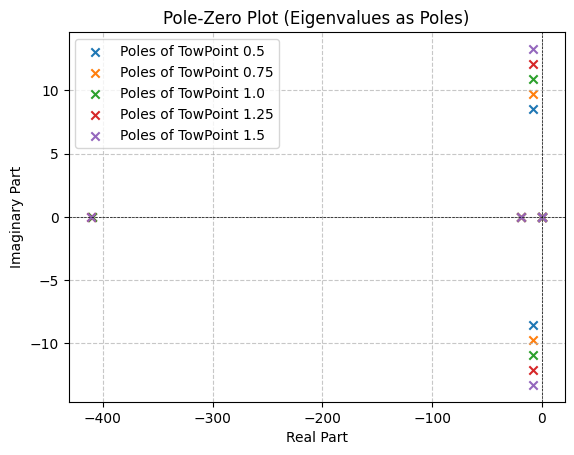

In [ ]:
r_xt = 42.9 * 10**(-3)
r_zt = -75 * 10**(-3)
TowPoint = [[r_xt*.5,r_zt*.5],[r_xt*.75,r_zt*.75],[r_xt,r_zt],[r_xt*1.25,r_zt*1.25],[r_xt*1.5,r_zt*1.5]]

eigs = []
input = ["TowPoint", [0.50,0.75,1.00,1.25,1.50]]
for r_t in TowPoint:
    sim.towingForce.location = [r_t[0],r_t[1]]
    jacobian, eigenvalues, eigenvectors, X_eq = sim.calculate_jacobian(2, 1e-7)
    eigs.append(eigenvalues)

# Create the main plot
fig, ax = plot.plot_poles(eigs, input)
sim.towingForce.location = [r_xt,r_zt]

##### Tail Length Sensitivity Sweep

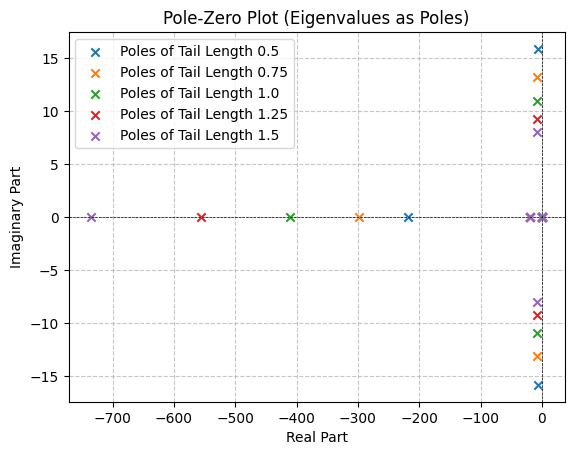

In [ ]:
r_xi = -111.76 * 10 ** (-3) #m 
Tails = [r_xi *0.5, r_xi*0.75, r_xi, r_xi*1.25, r_xi*1.5]
eigs = []
input = ["Tail Length", [0.50,0.75,1.00,1.25,1.50]]
for r_x in Tails:
    sim.controlForces[0].location[0] = r_x
    jacobian, eigenvalues, eigenvectors, X_eq = sim.calculate_jacobian(2, 1e-7)
    eigs.append(eigenvalues)
plot.plot_poles(eigs, input)
sim.controlForces[0].location[0] = r_xi


##### Foil Size Sensitivity Sweep

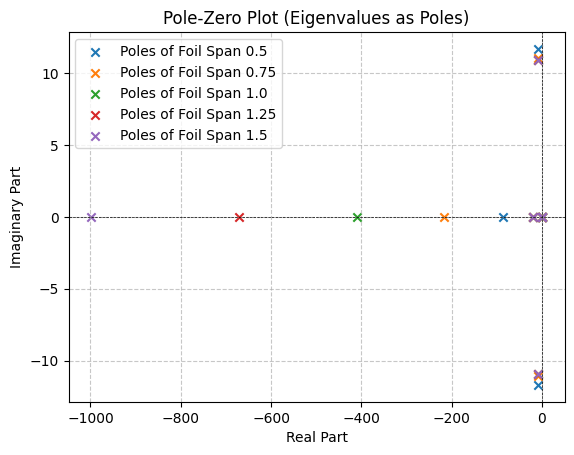

In [ ]:
span = [ctrl_span*0.5, ctrl_span*.75, ctrl_span, ctrl_span*1.25, ctrl_span*1.5]

eigs = []
input = ["Foil Span", [0.50,0.75,1.00,1.25,1.50]]
for s in span:
    sim.controlForces[0].Area = s*ctrl_chord
    sim.controlForces[0].AR = s/ctrl_chord
    jacobian, eigenvalues, eigenvectors, X_eq = sim.calculate_jacobian(2, 1e-7)
    eigs.append(eigenvalues)
plot.plot_poles(eigs, input)

# Reset model
ctrl_chord = 0.1
ctrl_span = 0.261
sim.controlForces[0].Area = ctrl_span*ctrl_chord
sim.controlForces[0].AR = ctrl_span/ctrl_chord